# 이 영화 재미있을까?
네이버영화 리뷰 댓글 감성분석을 통해 영화의 재미 유무를 파악해보자!

## 목차

### 1. 기본 baseline
> **가장 기본적인 형태로 3가지 모델을 통해 word2vec 학습한 후 비교**
- 데이터전처리**(결측치 및 중복 데이터, 길이, 문장 전처리)**
- 형태소 분석**(트콘화 및 불용어 제거)**
- 단어사전 만들기
- 단어 인코더, 디코더 정의
- 데이터셋 생성**(maxlen 결정, padding 적용)**
- Model 정의**(3가지 모델 : LSTM, GRU, CNN)**
- 학습
- 평가**(3가지 모델 비교)**

### 2. 사전 학습된 word2vec 비교
> **사전학습된 word2vec를 불러와 직접 학습한 word2vec과 비교<br>
Embedding layer의 train 버젼과 non-train 버젼 비교**

### 3. 다양한 형태소 분석기 비교
> **Mecab(기본), Khaiii(인공지능 기반)**

### 4. 결과 및 고찰

In [89]:
import pandas as pd
import os
import re

import numpy as np
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from konlpy.tag import Okt

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core import display as ICD
np.random.seed(40)

# 기본 Baseline
<hr>

In [90]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/Exploration/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/Exploration/sentiment_classification/data/ratings_test.txt')

ICD.display(train_data.head(3))
ICD.display(test_data.head(3))

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0


# 데이터 전처리(Preprocessing)

### 결측치 제거

In [91]:
train_data = train_data.dropna(how='any')         # Nan값 삭제하기(Train)
test_data = test_data.dropna(how='any')           # Nan값 삭제하기(Test)

print('Drop NaN Completed')

Drop NaN Completed


### 문장 전처리

In [92]:
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,¿])", "", sentence)   # 특수문자 제거
    sentence = sentence.strip()                      # 위 과정 이후에 생긴 문장 양쪽 끝 공백 제거
    
    return sentence

train_data['document'] = train_data['document'].apply(preprocess_sentence)     # 전처리 함수 적용
test_data['document'] = test_data['document'].apply(preprocess_sentence)       # 전처리 함수 적용
print('Preprocessing completed')
print(train_data.shape)
print(test_data.shape)

Preprocessing completed
(149995, 3)
(49997, 3)


### 중복 데이터 및 길이 1 이하 제거

In [93]:
ICD.display(train_data[train_data.duplicated(subset='document', keep=False)].sort_values(by='document').head(4))

train_data = train_data.drop_duplicates(subset='document')             # 중복데이터 제거(Train)
test_data = test_data.drop_duplicates(subset='document')               # 중복데이터 제거(Test)
print('Drop duplicated data Completed')

ICD.display(train_data[train_data['document'].str.len() == 1].head(3))

train_data = train_data[train_data['document'].str.len() > 1]          # 길이가 1보다 짧은 내용은 삭제(Train)
test_data = test_data[test_data['document'].str.len() > 1]             # 길이가 1보다 짧은 내용은 삭제(Test)

print('Shape of Train Dataset : ', train_data.shape)
print('Shape of Test Dataset : ', test_data.shape)

,id,document,label
142356,7130897,,1
38052,7863225,,1
25914,7481217,,0
147956,7205092,,0


Drop duplicated data Completed


,id,document,label
151,7348295,아,0
384,7679615,잼,1
549,6825866,끙,0


Shape of Train Dataset :  (144681, 3)
Shape of Test Dataset :  (48729, 3)


# 형태소 분석
- 토큰화
- 불용어 제거(Stopwords)

In [94]:
from konlpy.tag import Mecab
tokenizer = Mecab()                # Tokenizer 정의

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [95]:
X_train_data = []
for sentence in train_data['document']:
    temp = tokenizer.morphs(sentence)                        # 형태소 분석
    temp = [w for w in temp if w not in stopwords]         # 불용어 제거
    X_train_data.append(temp)

X_test_data = []
for sentence in test_data['document']:                     
    temp = tokenizer.morphs(sentence)                        # 형태소 분석
    temp = [w for w in temp if w not in stopwords]         # 불용어 제거
    X_test_data.append(temp)

print(X_train_data[:5])
print(X_test_data[:5])
print(len(X_train_data))
print(len(X_test_data))

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다'], ['교도소', '이야기', '구먼', '솔직히', '재미', '없', '다', '평점', '조정'], ['사이몬페그', '익살', '스런', '연기', '돋보였', '던', '영화', '스파이더맨', '에서', '늙', '어', '보이', '기', '만', '했', '던', '커스틴', '던스트', '너무나', '이뻐', '보였', '다']]
[['굳', 'ㅋ'], ['GDNTOPCLASSINTHECLUB'], ['뭐', '야', '평점', '나쁘', '진', '않', '지만', '10', '점', '짜리', '더더욱', '아니', '잖아'], ['지루', '하', '지', '않', '은데', '완전', '막장', '임', '돈', '주', '고', '보', '기'], ['3', 'D', '만', '아니', '었', '어도', '별', '다섯', '개', '줬', '을', '텐데', '왜', '3', 'D', '로', '나와서', '제', '심기', '불편', '하', '게', '하', '죠']]
144681
48729


# 단어사전 만들기

In [96]:
words = np.concatenate(X_train_data).tolist()                            # 데이터 한 줄로 펼치기
word_count = Counter(words).most_common(10000 - 3)                       # 각 단어별 사용 개수 계산

word_to_index = {data[0]:i+3 for i, data in enumerate(word_count)}       # word : index 형태의 단어사전 만들기
word_to_index['<PAD>'] = 0                                                # <PAD> 토큰 추가
word_to_index['<UNK>'] = 1                                                # <UNK> 토큰 추가
word_to_index['<BOS>'] = 2                                                # <BOS> 토큰 추가

index_to_word = {num:word for word, num in word_to_index.items()}         # index : word 형태의 단어사전 만들기
index_to_word = dict(sorted(index_to_word.items(), key=lambda x: x[0]))   # index 순으로 단어사전 정렬

print(len(word_to_index))
print(len(index_to_word))

10000
10000


# 위 과정을 한 번에 실시
전처리 과정 및 Konlpy 형태소 분석기를 이용한 형태소 분석을 한 번에 실시
- 데이터 전처리
- 형태소 분석
- 단어사전 만들기

In [97]:
def load_data(dataset, tokenizer, train, num_words=10000, stopwords=stopwords):   
    dataset = dataset.dropna(how='any')                                          # NaN 값 제거
    dataset['document'] = dataset['document'].apply(preprocess_sentence)         # 문장 전처리 적용
    dataset = dataset.drop_duplicates(subset=['document'])                       # 중복 데이터 제거
    dataset = dataset[dataset['document'].str.len() > 1]                         # 길이가 2보다 짧은 데이터 삭제
    
    X_input = []                               # Train X 데이터 만들기
    for sentence in dataset['document']:
        tokens = tokenizer.morphs(sentence)
        tokens = [word for word in tokens if word not in stopwords]
        X_input.append(tokens)
    
    Y_output = dataset['label'].to_numpy()    # Train Y 데이터 만들기
    
    if train:    # Train 데이터를 만들 시 단어사전(Word_to_index) 까지 같이 만들기
        word_list = np.concatenate(X_input).tolist()
        counter = Counter(word_list).most_common(10000-3)
        
        word_to_index = {}
        word_to_index['<PAD>'] = 0
        word_to_index['<UNK>'] = 1
        word_to_index['<BOS>'] = 2
        for idx, data in enumerate(counter):
            word, _ = data
            word_to_index[word] = idx + 3
        
        return X_input, Y_output, word_to_index
    
    return X_input, Y_output   # Test 데이터 만들 시 단어사전(word_to_index)는 생략

X_train_data, Y_train_data, word_to_index = load_data(train_data, tokenizer, train=True)
X_test_data, Y_test_data = load_data(test_data, tokenizer, train=False)

print(len(X_train_data), len(Y_train_data))
print(len(X_test_data), len(Y_test_data))

144681 144681
48729 48729


# 단어 인코더, 디코더

### 단어 임베딩 함수로 합치기

In [98]:
def encode_sentences(sentences, word_to_index=word_to_index):    # 단어들을 숫자로 변환하는 함수
    encoded_sentences = []
    
    for sentence in sentences:
        new_sentence = [word_to_index['<BOS>']]                    # 시작하는 부분 BOS(Begin of Sting) 추가
        
        for word in sentence:
            if word in word_to_index:
                new_sentence.append(word_to_index[word])          # 단어사전에 단어가 있으면 해당 index로 변환
            else: 
                new_sentence.append(word_to_index['<UNK>'])       # 단어사전에 특정 단어가 없으면 <UNK> 토큰으로 대체
                
        encoded_sentences.append(new_sentence)
        
    return encoded_sentences

def decode_sentences(sentences, index_to_word=index_to_word):    # 숫자들을 단어로 변환하는 함수
    decoded_sentences = []
    
    for sentence in sentences:
        new_sentence = []
        
        for idx in sentence:
            if idx in index_to_word:
                new_sentence.append(index_to_word[idx])              # 단어사전에 index를 단어로 변환
            else:
                new_sentence.append(word_to_index[1])
                
        decoded_sentences.append(' '.join(new_sentence))
        
    return decoded_sentences

print(X_train_data[0])
print(encode_sentences([X_train_data[0]]))

['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리']
[[2, 26, 68, 950, 33, 223, 14, 27, 735]]


# 데이터셋 생성
Padding 설정 시 Max Len의 길이를 설정해줘야 하기 때문에 분석을 통해 적절한 크기 결정
- 전체 길이 중 90퍼에 해당하는 길이를 MaxLen으로 결정!

### Max len 결정

The 90% of Length : 30.0


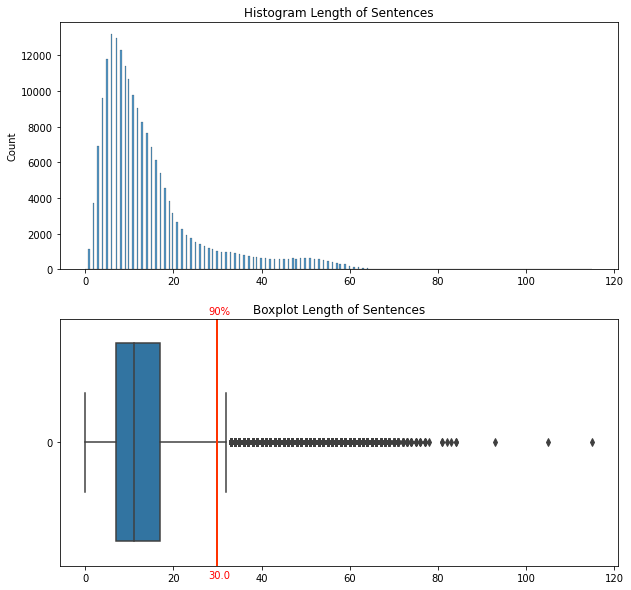

In [99]:
dataset = X_train_data + X_test_data                  # 전체 데이터에서 길이의 분포를 파악하기 위해 Train Test 합치기
train_len = len(X_train_data)
sentence_len = [len(sent) for sent in dataset]        # 각 데이터들의 길이 종합

percent = 90
max_len = np.percentile(sentence_len, percent)        # 특정 Percent에 해당하는 데이터 길이 출력(90퍼로 결정)

plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
sns.histplot(sentence_len)
plt.title('Histogram Length of Sentences')

plt.subplot(2,1,2)
sns.boxplot(data=sentence_len, orient='h')
plt.axvline(x=max_len, color='#ff3300', linewidth=2, label='Threshold Value')  # 빨간 표시줄 그리기
plt.text(max_len-2, -0.52, '90%', color='red')                                 # 빨간 표시줄 xtick(위)
plt.text(max_len-2,0.55, max_len, color='red')                                 # 빨간 표시줄 xtick(아래)
plt.title('Boxplot Length of Sentences')

print(f'The {percent}% of Length :', max_len)
plt.show()

### Padding 적용
> **한글은 문장의 뒷부분에 핵심 내용이 포함되기 때문에 Padding의 방향을 'pre'로 설정**

In [100]:
X_train = encode_sentences(X_train_data)                 # 단어들을 숫자로 변환
Y_train = Y_train_data

X_test = encode_sentences(X_test_data)                   # 단어들을 숫자로 변환
Y_test = Y_test_data

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                     value=word_to_index['<PAD>'],    # max len보다 짧으면 <PAD> 토큰으로 대체
                                                     padding='pre',                   # padding을 문장 앞에 적용
                                                     maxlen=int(max_len))
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                     value=word_to_index['<PAD>'],
                                                     padding='pre',
                                                     maxlen=int(max_len))
X_train[:5]
print('Shape of Train : ', X_train.shape, Y_train.shape)
print('Shape of Train : ', X_test.shape, Y_test.shape)

Shape of Train :  (144681, 30) (144681,)
Shape of Train :  (48729, 30) (48729,)


# Model
3가지 모델을 이용하여 성능 비교
1. model_lstm
2. model_gru
3. model_cnn
> **LSTM 모델이 가장 좋은 성능을 보여 앞으로 있을 여러 실험에 LSTM을 사용**

### LSTM model

In [101]:
vocab_size = len(word_to_index)
word_vector_dim = 128

model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) # Embedding layer 학습
model_lstm.add(keras.layers.LSTM(8))
model_lstm.add(keras.layers.Dense(8, activation='relu'))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 128)         1280000   
_________________________________________________________________
lstm_18 (LSTM)               (None, 8)                 4384      
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 9         
Total params: 1,284,465
Trainable params: 1,284,465
Non-trainable params: 0
_________________________________________________________________


### GRU model

In [102]:
vocab_size = len(word_to_index)
word_vector_dim = 128

model_gru = keras.Sequential()
model_gru.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gru.add(tf.keras.layers.GRU(8))
model_gru.add(keras.layers.Dense(8, activation='relu'))
model_gru.add(keras.layers.Dense(1, activation='sigmoid'))

model_gru.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 128)         1280000   
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 3312      
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 9         
Total params: 1,283,393
Trainable params: 1,283,393
Non-trainable params: 0
_________________________________________________________________


### CNN model

In [103]:
from tensorflow.keras.layers import LSTM

vocab_size = len(word_to_index)
word_vector_dim = 128

model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(keras.layers.Conv1D(16, 5, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(8, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 128)         1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          10256     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 9         
Total params: 1,290,401
Trainable params: 1,290,401
Non-trainable params: 0
_________________________________________________________________


# 학습

### Train & Val Dataset 나누기
Train : 80% / val : 20%

In [104]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2) # 

print('Train size : ', x_train.shape, y_train.shape)
print('Val size : ', x_val.shape, y_val.shape)
print('Test size : ', X_test.shape, Y_test.shape)

Train size :  (115744, 30) (115744,)
Val size :  (28937, 30) (28937,)
Test size :  (48729, 30) (48729,)


### Model 컴파일 및 학습

In [105]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

EPOCH=20

history_lstm = model_lstm.fit(x_train, y_train, epochs=EPOCH, batch_size=512, validation_data=(x_val, y_val), verbose=0)
print('LSTM Finished')
history_gru = model_gru.fit(x_train, y_train, epochs=EPOCH, batch_size=512, validation_data=(x_val, y_val), verbose=0)
print('GRU Finished')
history_cnn = model_cnn.fit(x_train, y_train, epochs=EPOCH, batch_size=512, validation_data=(x_val, y_val), verbose=0)
print('CNN Finished')

LSTM Finished
GRU Finished
CNN Finished


### 학습결과 시각화

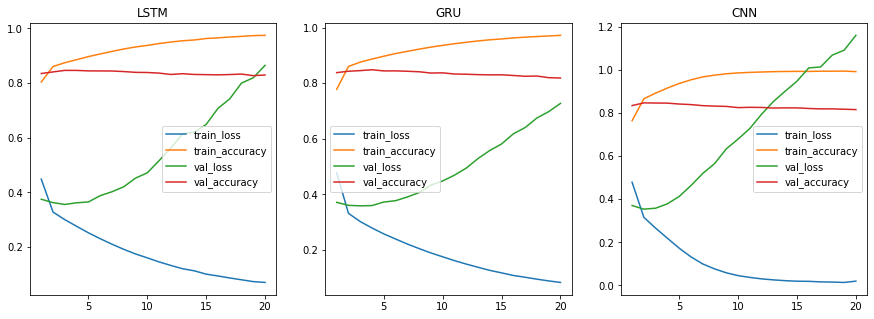

In [106]:
def plot_history(history_dict):
    train_loss = history_dict['loss']
    train_acc = history_dict['accuracy']
    val_loss = history_dict['val_loss']
    val_acc = history_dict['val_accuracy']
    
    epoch_range = range(1,EPOCH+1)
    
    plt.plot(epoch_range, train_loss)
    plt.plot(epoch_range, train_acc)
    plt.plot(epoch_range, val_loss)
    plt.plot(epoch_range, val_acc)
    plt.legend(['train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

history_lstm_dict = history_lstm.history
history_gru_dict = history_gru.history
history_cnn_dict = history_cnn.history

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plot_history(history_lstm_dict); plt.title('LSTM')
plt.subplot(1,3,2); plot_history(history_gru_dict); plt.title('GRU')
plt.subplot(1,3,3); plot_history(history_cnn_dict); plt.title('CNN')

plt.show()

### 해석
- Train loss가 감소하지만 val_loss가 증가한 것으로 보아 overfitting이 되었다고 판단

# 평가

1523/1523 - 4s - loss: 0.8390 - accuracy: 0.8288
1523/1523 - 4s - loss: 0.7055 - accuracy: 0.8235
1523/1523 - 2s - loss: 1.1205 - accuracy: 0.8189


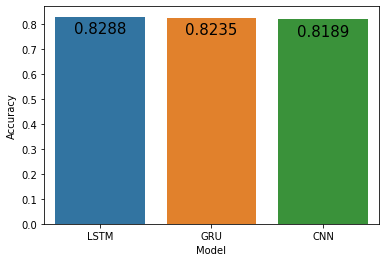

In [107]:
_, lstm_acc = model_lstm.evaluate(X_test, Y_test, verbose=2)
_, gru_acc = model_gru.evaluate(X_test, Y_test, verbose=2)
_, cnn_acc = model_cnn.evaluate(X_test, Y_test, verbose=2)

df_eval = pd.DataFrame({'Model' : ['LSTM', 'GRU', 'CNN'], 
                        'Accuracy' : [lstm_acc, gru_acc, cnn_acc]})

splot = sns.barplot(x='Model', y='Accuracy', data=df_eval)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

# 사전학습 word2vec 비교
<hr>

### 직접 학습한 word2vec 추출

In [108]:
# model에서 Embedding weights(== word vectors) 추출
embedding_layer = model_lstm.layers[0]
vectors = embedding_layer.get_weights()[0]

# Embedding weight 저장
word2vec_file_path = os.getenv('HOME') + '/aiffel/Exploration/sentiment_classification/data/word2vec.txt'
with open(word2vec_file_path, 'w') as f:
    f.write(f'{vocab_size-3} {word_vector_dim}\n')
    
    word_vector = model_lstm.get_weights()[0]
    for i in range(3, vocab_size):
        f.write(f"{index_to_word[i]} {' '.join(list(map(str, vectors[i])))}\n")
    f.close()

# Embedding weight 불러오기
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word2vec.similar_by_word('영화')[:5]

[('습니다', 0.7089802622795105),
 ('또', 0.6827924251556396),
 ('애니메이션', 0.6789795160293579),
 ('됨', 0.6632970571517944),
 ('^', 0.6501381993293762)]

### 사전학습된 word2vec 불러오기

In [109]:
import gensim
import os

word2vec_path = os.getenv('HOME') + '/aiffel/Exploration/sentiment_classification/data/ko.bin'
word2vec_pre = gensim.models.Word2Vec.load(word2vec_path)
word2vec_pre.wv.similar_by_word('영화')[:5]

[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797)]

### 사전학습된 word2vec으로 Embedding Matrix 만들기

In [110]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.randn(vocab_size, word_vector_dim)

for i in range(vocab_size):
    if index_to_word[i] in word2vec_pre.wv:
        embedding_matrix[i] = word2vec_pre.wv[index_to_word[i]]

### 학습

In [111]:
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2)

print('Train size : ', x_train.shape, y_train.shape)
print('Val size : ', x_val.shape, y_val.shape)
print('Test size : ', X_test.shape, Y_test.shape)

vocab_size = 10000 
word_vector_dim = 200  

model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, 
                                      embeddings_initializer=Constant(embedding_matrix), 
                                      input_shape=(None,),
                                      trainable=True))
model_lstm.add(keras.layers.LSTM(8))
model_lstm.add(keras.layers.Dense(8, activation='relu'))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

EPOCH = 20
history_lstm_pre_train = model_lstm.fit(x_train, y_train, epochs=EPOCH, batch_size=512, validation_data=(x_val, y_val), verbose=2)

Train size :  (115744, 30) (115744,)
Val size :  (28937, 30) (28937,)
Test size :  (48729, 30) (48729,)
Epoch 1/20
227/227 - 7s - loss: 0.5455 - accuracy: 0.7196 - val_loss: 0.4309 - val_accuracy: 0.8073
Epoch 2/20
227/227 - 5s - loss: 0.3915 - accuracy: 0.8286 - val_loss: 0.3800 - val_accuracy: 0.8321
Epoch 3/20
227/227 - 4s - loss: 0.3446 - accuracy: 0.8532 - val_loss: 0.3623 - val_accuracy: 0.8419
Epoch 4/20
227/227 - 4s - loss: 0.3168 - accuracy: 0.8677 - val_loss: 0.3565 - val_accuracy: 0.8463
Epoch 5/20
227/227 - 4s - loss: 0.2956 - accuracy: 0.8783 - val_loss: 0.3600 - val_accuracy: 0.8473
Epoch 6/20
227/227 - 4s - loss: 0.2800 - accuracy: 0.8857 - val_loss: 0.3599 - val_accuracy: 0.8467
Epoch 7/20
227/227 - 4s - loss: 0.2662 - accuracy: 0.8926 - val_loss: 0.3631 - val_accuracy: 0.8476
Epoch 8/20
227/227 - 4s - loss: 0.2533 - accuracy: 0.8995 - val_loss: 0.3714 - val_accuracy: 0.8473
Epoch 9/20
227/227 - 4s - loss: 0.2412 - accuracy: 0.9050 - val_loss: 0.3729 - val_accuracy: 0.8

### 학습결과 비교

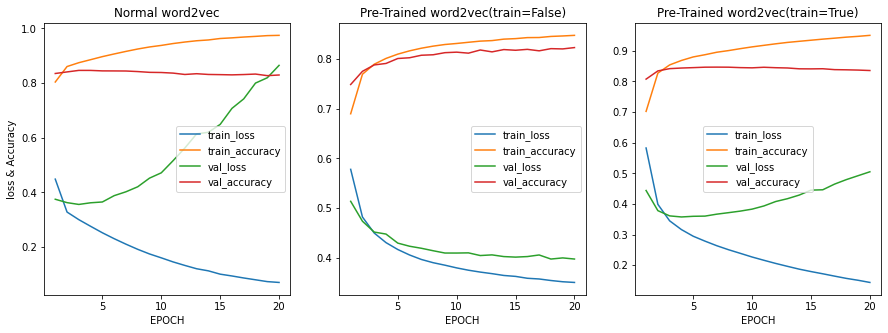

In [112]:
history_lstm_dict_pre = history_lstm_pre.history

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plot_history(history_lstm_dict); plt.xlabel('EPOCH'); plt.ylabel('loss & Accuracy')
plt.title('Normal word2vec')
plt.subplot(1,3,2); plot_history(history_lstm_dict_pre); plt.xlabel('EPOCH')
plt.title('Pre-Trained word2vec(train=False)')
plt.subplot(1,3,3); plot_history(history_lstm_dict_pre_train); plt.xlabel('EPOCH')
plt.title('Pre-Trained word2vec(train=True)')
plt.show()

### 해석
- 우선 Pre-Trained된 word2vec를 사용하면 비교적 overfitting 덜 발생
- 또한 Embedding Layer 부분의 파라미터를 학습하지 않고 진행하면 안정적인 학습이 이루어짐
> **Pre-Trained된 word2vec을 이용하고, Train을 off한 상태로 학습을 진행하는게 가장 이상적인 학습방법**

### 정확도 비교
직접 학습한 word2vec와 사전 학습된 word2vec의 정확도 비교
- 위 과정에서 정확도가 가장 높게 나온 LSTM 모델로 비교

1523/1523 - 4s - loss: 0.5252 - accuracy: 0.8326


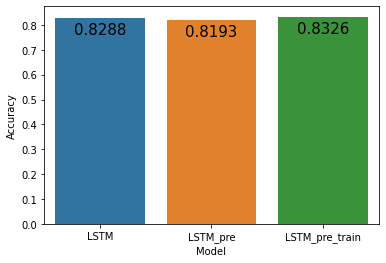

In [113]:
_, lstm_acc_pre_train = model_lstm.evaluate(X_test, Y_test, verbose=2)

df_eval_pre = pd.DataFrame({'Model' : ['LSTM', 'LSTM_pre', 'LSTM_pre_train'], 
                        'Accuracy' : [lstm_acc, lstm_acc_pre, lstm_acc_pre_train]})

splot = sns.barplot(x='Model', y='Accuracy', data=df_eval_pre)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
    
plt.show()

# 다양한 형태소 분석기 비교
<hr>

1. Konlpy(Mecab)
2. Khaiii : CNN 방식을 이용하는 형태소 분석기

### Konlpy(Mecab)

In [114]:
from konlpy.tag import Mecab, Kkma, Okt
tokenizer_mecab = Mecab()
tokenizer_kkma = Kkma()
tokenizer_okt = Okt()

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

train_mecab_x, train_mecab_y, word_to_index_mecab = load_data(train_data, tokenizer_mecab, train=True)
test_mecab_x, test_mecab_y = load_data(test_data, tokenizer_mecab, train=False)
print('Mecab Finished')

Mecab Finished


### Khaiii
직접 Khaiii 라이브러리를 설치해야 사용 가능[Khaiii 설치](https://github.com/kakao/khaiii)
- Window에는 실행이 불가하기 때문에 cloud 환경을 이용
- 따로 document를 제공하지 않아 좀 불편함. 하나씩 메소드를 실행하면서 파악해야함

In [115]:
from khaiii import KhaiiiApi 

api = KhaiiiApi()                                   # Khaiii 클래스 불러오기

train_khaiii_x = []
train_khaiii_y = train_data['label'].to_numpy()
for sentence in train_data['document']:
    analyzed = api.analyze(sentence)                # 형태소 분석
    
    morphs_list = []
    for word in analyzed:            
        for morph in word.morphs:                  # 분석한 결과 (단어, tagging) 형식으로 출력
            morphs_list.append(morph.lex)           # (단어, tagging) 중 단어(lex)만 추출
    train_khaiii_x.append(morphs_list)

test_khaiii_x = []
test_khaiii_y = test_data['label'].to_numpy()
for sentence in test_data['document']:
    analyzed = api.analyze(sentence)
    
    morphs_list = []
    for word in analyzed:                          # 형태소 분석
        for morph in word.morphs:                  # 분석한 결과 (단어, tagging) 형식으로 출력
            morphs_list.append(morph.lex)           # (단어, tagging) 중 단어(lex)만 추출
    test_khaiii_x.append(morphs_list)
    
# 단어사전 만들기
words_khaiii = np.concatenate(train_khaiii_x).tolist()
word_count_khaiii = Counter(words_khaiii).most_common(10000 - 3)

word_to_index_khaiii = {data[0]:i+3 for i, data in enumerate(word_count_khaiii)}
word_to_index_khaiii['<PAD>'] = 0
word_to_index_khaiii['<UNK>'] = 1
word_to_index_khaiii['<BOS>'] = 2

index_to_word_khaiii = {num:word for word, num in word_to_index_khaiii.items()}
index_to_word_khaiii = dict(sorted(index_to_word_khaiii.items(), key=lambda x: x[0]))

print(len(word_to_index_khaiii))
print(len(index_to_word_khaiii))

10000
10000


### 학습
함수로 정의해서 편리하게 사용

In [116]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def train(X_trian, Y_train, word_to_index, name):
    X_train = encode_sentences(X_trian)
    X_train = pad_sequences(X_train, value=word_to_index['<PAD>'], padding='pre', maxlen=30)
    
    x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2)
    
    print(x_train.shape)
    vocab_size = len(word_to_index)
    word_vector_dim = 128

    model_lstm = keras.Sequential()
    model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model_lstm.add(keras.layers.LSTM(8))
    model_lstm.add(keras.layers.Dense(8, activation='relu'))
    model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    EPOCH=20

    history_lstm = model_lstm.fit(x_train, y_train, epochs=EPOCH, batch_size=512, validation_data=(x_val, y_val), verbose=0)
    print(f'{name} Finished')
    
    return history_lstm, model_lstm

history_mecab, mecab_model = train(train_mecab_x, train_mecab_y, word_to_index_mecab, name='mecab')
history_khaiii, khaiii_model = train(train_khaiii_x, train_khaiii_y, word_to_index_khaiii, name='khaiii')

(115744, 30)
mecab Finished
(115744, 30)
khaiii Finished


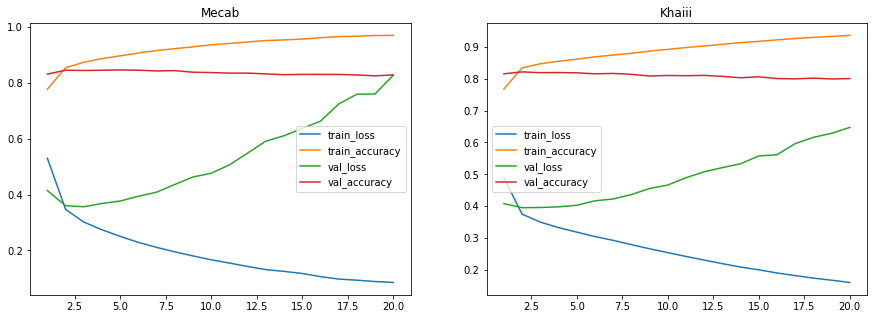

In [117]:
history_mecab_dict = history_mecab.history
history_khaiii_dict = history_khaiii.history

plt.figure(figsize=(15,5))
plt.subplot(1,2,1); plot_history(history_mecab_dict); plt.title('Mecab')
plt.subplot(1,2,2); plot_history(history_khaiii_dict); plt.title('Khaiii')

plt.show()

1523/1523 - 3s - loss: 0.8168 - accuracy: 0.8295
1523/1523 - 3s - loss: 0.6382 - accuracy: 0.8040


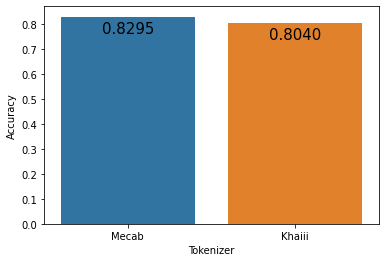

In [118]:
def val(X_test, Y_test, model, word_to_index):
    X_test = encode_sentences(X_test)
    X_test = pad_sequences(X_test, value=word_to_index['<PAD>'], padding='pre', maxlen=30)

    _, tokenizer_acc = model.evaluate(X_test, Y_test, verbose=2)
    
    return tokenizer_acc

mecab_acc = val(test_mecab_x, test_mecab_y, mecab_model, word_to_index_mecab)
khaiii_acc = val(test_khaiii_x, test_khaiii_y, khaiii_model, word_to_index_khaiii)

df_eval = pd.DataFrame({'Tokenizer' : ['Mecab', 'Khaiii'], 
                        'Accuracy' : [mecab_acc, khaiii_acc]})

splot = sns.barplot(x='Tokenizer', y='Accuracy', data=df_eval)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

# 결과 및 고찰
- 3가지 모델(LSTM, GRU, CNN) 중 LSTM 모델이 가장 성능이 좋음
- Konlpy에 다양한 형태소 분석기(Kkma, Okt 등)이 있지만 시간이 너무 오래 걸려서 포기
- 2가지 형태소 분석기(Mecab, Khaiii) 실험을 통해 Mecab이 더 좋다고 판단
  - **Khaiii의 경우 너무 세부적으로 나누는 특징이 있음**
  - **따라서 Khaiii의 경우 깔끔한 문장에 대해서는 매우 좋은 성능을 보이지만, 댓글 같이 오타가 많은 것에는 성능이 좋지 않음**
- 사실 데이터셋을 쭉 보면 잘못 labeling 된 데이터들도 보이기 때문에 신빙성이 없음
- 데이터 전처리가 더 많으면 성능이 확실히 더 오를것으로 판단이 됨
> **Pre-Trained word2vec을 이용해 Embedding Layer의 train을 off한 상태로 데이터를 학습하면 좋은 결과가 나올 것으로 판단**